In [1]:
import fiftyone as fo

# Delete all datasets
print(fo.list_datasets())


['coffee_fruits']


In [3]:
import fiftyone as fo

# Delete the specific dataset
if "coffee_fruits" in fo.list_datasets():
    fo.delete_dataset("coffee_fruits")
    print("Dataset 'coffee_fruits' deleted successfully!")
else:
    print("Dataset 'coffee_fruits' not found.")

Dataset 'coffee_fruits' deleted successfully!


In [4]:
import fiftyone as fo
import fiftyone.zoo as foz
import fiftyone.utils.coco as fouc

# Define dataset parameters
dataset_name = "coffee_fruits"
coco_annotations_path = "/home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/annotations/instances_default.json"  # Change this to the actual path
dataset_images_dir = "/home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images"  # Change this to the actual path

# Load the COCO dataset persistently
dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    dataset_dir=dataset_images_dir,
    data_path=dataset_images_dir,
    labels_path=coco_annotations_path,
    name=dataset_name,
    persistent=True,
)



 100% |███████████████| 1593/1593 [8.8s elapsed, 0s remaining, 93.6 samples/s]       


In [5]:


# Print dataset summary
print(dataset)

Name:        coffee_fruits
Media type:  image
Num samples: 1593
Persistent:  True
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    detections:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    segmentations:    fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)



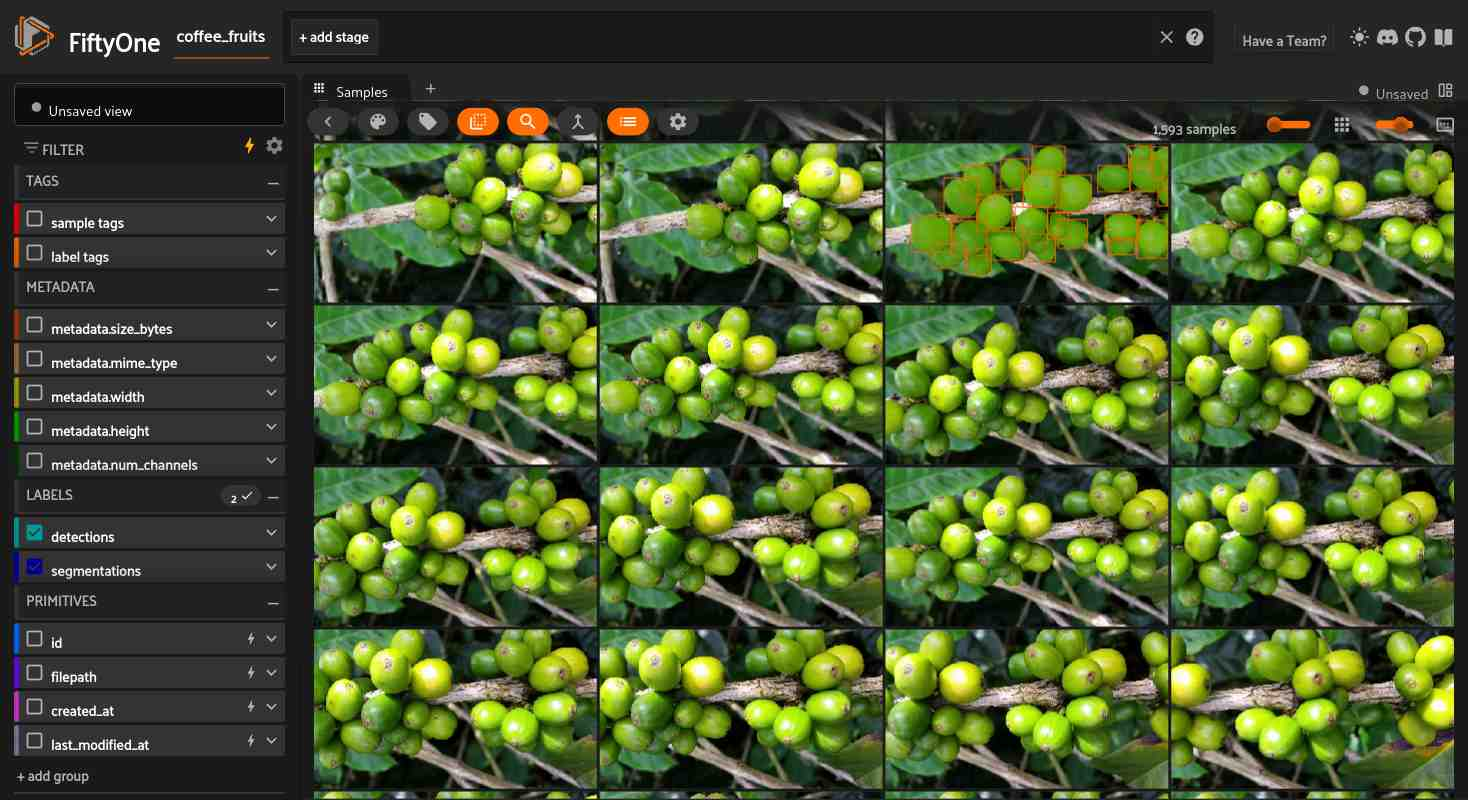

Dataset sample labels:
<Sample: {
    'id': '67a27482999671d9b01ef2f8',
    'media_type': 'image',
    'filepath': '/home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_62.jpg',
    'tags': [],
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 1920,
        'height': 1080,
        'num_channels': None,
    }>,
    'created_at': datetime.datetime(2025, 2, 4, 20, 11, 46, 944000),
    'last_modified_at': datetime.datetime(2025, 2, 4, 20, 11, 46, 944000),
    'detections': None,
    'segmentations': None,
}>


In [6]:
# Launch the FiftyOne App to explore
session = fo.launch_app(dataset)

# Show some random samples
print("Dataset sample labels:")
print(dataset.first())

In [15]:
# Define label colors
label_colors = {
    "mature": "#FF0000",      # Red
    "immature": "#008000",    # Green
    "semimature": "#FFFF00",  # Yellow
    "overmature": "#800080"   # Purple
}

dataset.default_classes = list(label_colors.keys())
dataset.default_mask_targets = {i+1: label for i, label in enumerate(label_colors.keys())}



In [7]:
import fiftyone.utils.random as four

four.random_split(dataset, {"train": 0.8, "val": 0.2})

In [11]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Import libraries
import numpy as np
import os
import cv2
import torch

# Import detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
import fiftyone as fo

# Ensure CUDA is available
if not torch.cuda.is_available():
    print("⚠️ Warning: CUDA is not available. Training will be slow on CPU!")

# Function to convert FiftyOne dataset to Detectron2 format
def get_fiftyone_dicts(samples):
    samples.compute_metadata()

    dataset_dicts = []
    for sample in samples.select_fields(["id", "filepath", "metadata", "segmentations"]):
        height = sample.metadata["height"]
        width = sample.metadata["width"]
        record = {
            "file_name": sample.filepath,
            "image_id": sample.id,
            "height": height,
            "width": width,
            "annotations": []
        }

        # Check if segmentations exist
        if not sample.segmentations or not sample.segmentations.detections:
            print(f"⚠️ Warning: Skipping sample {sample.filepath} (No segmentations)")
            continue  # Skip this sample

        objs = []
        for det in sample.segmentations.detections:
            if not det.bounding_box:
                print(f"⚠️ Warning: Skipping detection in {sample.filepath} (No bounding box)")
                continue

            # Convert bounding box
            tlx, tly, w, h = det.bounding_box
            bbox = [int(tlx * width), int(tly * height), int(w * width), int(h * height)]

            # Convert segmentation mask to polygon (Ensure it's valid)
            fo_poly = det.to_polyline()
            if fo_poly is None or not fo_poly.points or len(fo_poly.points[0]) < 6:
                print(f"⚠️ Warning: Skipping detection in {sample.filepath} (Invalid segmentation mask)")
                continue

            poly = [(x * width, y * height) for x, y in fo_poly.points[0]]
            poly = [p for x in poly for p in x]  # Flatten list

            if len(poly) < 6:  # Must have at least 3 points (6 values)
                print(f"⚠️ Warning: Skipping detection in {sample.filepath} (Polygon has fewer than 3 points)")
                continue

            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYWH_ABS,
                "segmentation": [poly],
                "category_id": 0,  # Single class: Coffee Fruits
            }
            objs.append(obj)

        # Add sample if it contains valid segmentations
        if objs:
            record["annotations"] = objs
            dataset_dicts.append(record)
        else:
            print(f"⚠️ Warning: No valid annotations for {sample.filepath}, skipping.")

    return dataset_dicts

# Function to register dataset safely
def register_fiftyone_dataset(name, view):
    if name in DatasetCatalog.list():
        print(f"✅ Dataset '{name}' is already registered. Skipping registration.")
    else:
        DatasetCatalog.register(name, lambda view=view: get_fiftyone_dicts(view))
        MetadataCatalog.get(name).set(thing_classes=["coffee_fruit"])

# Register dataset for training & validation
for d in ["train", "val"]:
    view = dataset.match_tags(d)
    register_fiftyone_dataset(f"fiftyone_{d}", view)

metadata = MetadataCatalog.get("fiftyone_train")

# Setup the configuration for training
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fiftyone_train",)
cfg.DATASETS.TEST = ("fiftyone_val",)
cfg.DATALOADER.NUM_WORKERS = 4

# Model output directory
cfg.OUTPUT_DIR = "./output"

# Set model weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

# Hyperparameters
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3000  # Number of iterations
cfg.SOLVER.STEPS = []  # No decay
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  # Faster training
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # Only one class: Coffee Fruit

# Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

✅ Dataset 'fiftyone_train' is already registered. Skipping registration.
✅ Dataset 'fiftyone_val' is already registered. Skipping registration.
[02/04 15:40:18 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_siz

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[02/04 15:40:25 d2.engine.train_loop]: Starting training from iteration 0
[02/04 15:40:27 d2.utils.events]:  eta: 0:06:25  iter: 19  total_loss: 2.317  loss_cls: 0.7154  loss_box_reg: 0.8421  loss_mask: 0.6825  loss_rpn_cls: 0.02277  loss_rpn_loc: 0.03183    time: 0.1274  last_time: 0.1157  data_time: 0.0104  last_data_time: 0.0017   lr: 4.9953e-06  max_mem: 2766M
[02/04 15:40:30 d2.utils.events]:  eta: 0:06:22  iter: 39  total_loss: 2.244  loss_cls: 0.6649  loss_box_reg: 0.8175  loss_mask: 0.6572  loss_rpn_cls: 0.03086  loss_rpn_loc: 0.04122    time: 0.1266  last_time: 0.1284  data_time: 0.0023  last_data_time: 0.0025   lr: 9.9902e-06  max_mem: 2766M
[02/04 15:40:32 d2.utils.events]:  eta: 0:06:19  iter: 59  total_loss: 2.095  loss_cls: 0.6085  loss_box_reg: 0.8197  loss_mask: 0.6089  loss_rpn_cls: 0.02638  loss_rpn_loc: 0.02798    time: 0.1252  last_time: 0.1242  data_time: 0.0023  last_data_time: 0.0018   lr: 1.4985e-05  max_mem: 2767M
[02/04 15:40:35 d2.utils.events]:  eta: 0:06:17

⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_62.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_63.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_58.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_60.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_56.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_51.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg


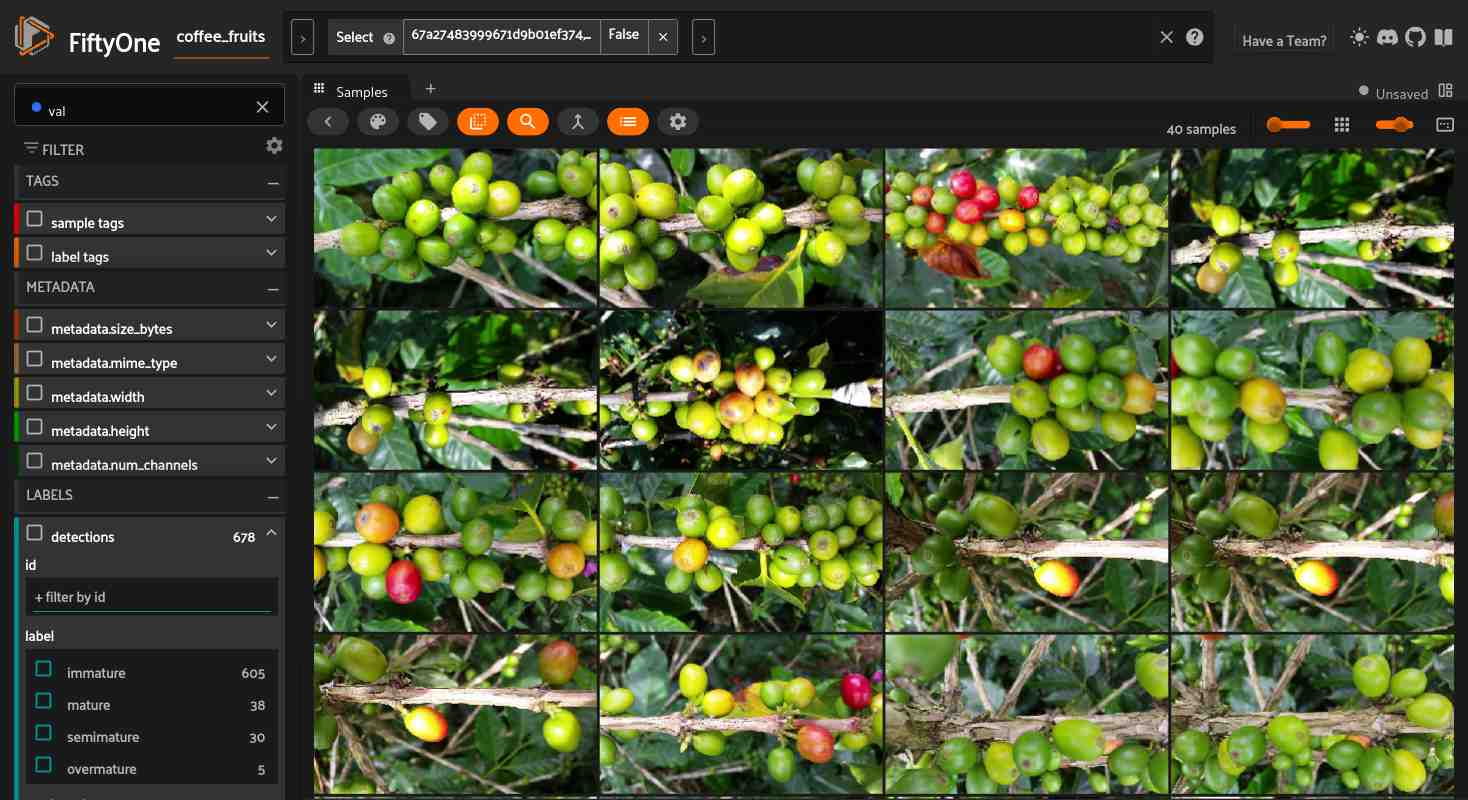

In [ ]:
dataset_dicts = get_fiftyone_dicts(dataset.match_tags("train"))
ids = [dd["image_id"] for dd in dataset_dicts]

view = dataset.select(ids)
session = fo.launch_app(view)

⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_61.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_54.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_57.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_43.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_37.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_36.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg


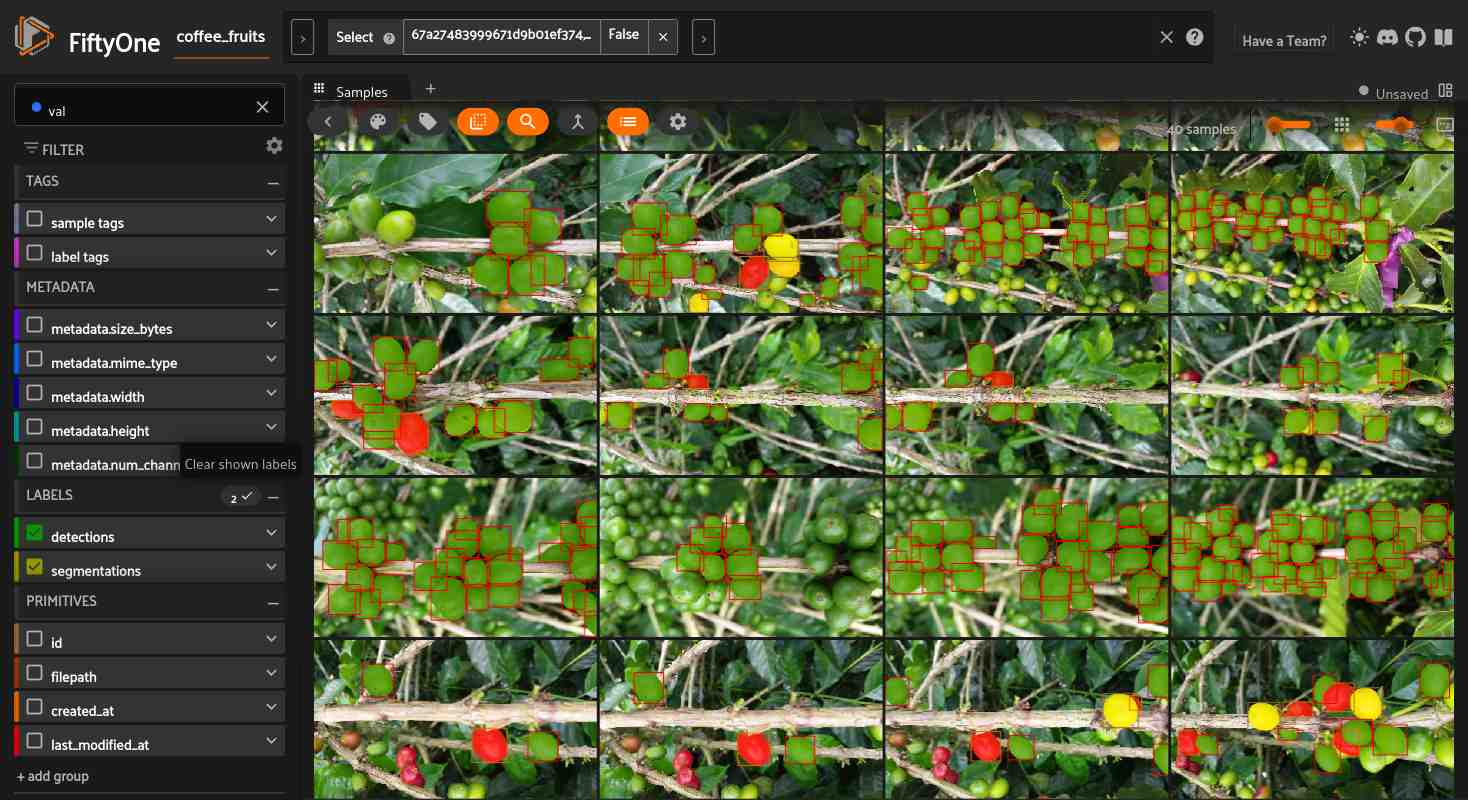

In [13]:
dataset_dicts = get_fiftyone_dicts(dataset.match_tags("val"))
ids = [dd["image_id"] for dd in dataset_dicts]

view = dataset.select(ids)
session = fo.launch_app(view)

In [14]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Define an evaluator for instance segmentation
evaluator = COCOEvaluator("fiftyone_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "fiftyone_val")

# Run evaluation
print("🔍 Running evaluation on validation set...")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [02/04 15:58:16 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[02/04 15:58:16 d2.evaluation.coco_evaluation]: Trying to convert 'fiftyone_val' to COCO format ...
[02/04 15:58:16 d2.data.datasets.coco]: Converting annotations of dataset 'fiftyone_val' to COCO format ...)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_61.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_54.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_57.jpg (No segmentations)
⚠️ Warning: Skipping sample /home/paula/projects/databricks/coffee_seg/colombian_coffee-dataset/images/lin_ln_20150813_093518_im_43.jpg (No segmentations)
⚠

OrderedDict([('bbox',
              {'AP': 80.01718896898934,
               'AP50': 90.63421347576022,
               'AP75': 89.48394132135505,
               'APs': nan,
               'APm': 70.96256460554717,
               'APl': 81.10509073349733}),
             ('segm',
              {'AP': 84.44449060513199,
               'AP50': 90.63421347576022,
               'AP75': 89.05903197054427,
               'APs': nan,
               'APm': 62.79826316513844,
               'APl': 86.16584117399664})])

In [15]:
import fiftyone as fo
import cv2
import numpy as np
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode
from fiftyone import ViewField as F

# Load validation dataset
val_view = dataset.match_tags("val")

# Initialize predictor with trained model
predictor = DefaultPredictor(cfg)

# Process each image in the validation set
for sample in val_view:
    img = cv2.imread(sample.filepath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get model predictions
    outputs = predictor(img)
    instances = outputs["instances"].to("cpu")

    detections = []
    for i in range(len(instances.pred_boxes)):
        # Get bounding box
        box = instances.pred_boxes[i].tensor.numpy()[0]
        bbox = [box[0] / img.shape[1], box[1] / img.shape[0], 
                (box[2] - box[0]) / img.shape[1], (box[3] - box[1]) / img.shape[0]]

        # Get segmentation mask
        mask = instances.pred_masks[i].numpy().astype(np.uint8)

        # Convert mask to binary image (0 or 1)
        mask = (mask * 255).astype(np.uint8)

        # Convert mask to polygon format
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        polygons = []
        for contour in contours:
            contour = contour.flatten().tolist()
            if len(contour) >= 6:  # Ensure valid polygon
                polygons.append(contour)

        # Get confidence score & class label
        confidence = float(instances.scores[i].numpy())
        label = "coffee_fruit"

        # Create FiftyOne Detection object
        detection = fo.Detection(
            label=label,
            bounding_box=bbox,
            confidence=confidence,
            mask=mask if len(polygons) > 0 else None,  # Store mask if valid
        )
        detections.append(detection)

    # Store predictions in FiftyOne
    sample["predictions"] = fo.Detections(detections=detections)
    sample.save()

# Launch FiftyOne App
session = fo.launch_app(view=val_view)

[02/04 16:04:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import fiftyone.core.labels as fol

# Load your model and weights
model = segmentation()  # Replace with your actual model class
model.load_state_dict(torch.load("/home/paula/projects/databricks/coffee_seg/maskrcnn_resnet50/weights.pth"))
model.eval()

# Define image transform (modify as needed)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Modify size as per your model
    transforms.ToTensor(),
])

# Iterate through dataset and make predictions
for sample in dataset:
    img = Image.open(sample.filepath).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        outputs = model(img_tensor)

    # Convert outputs to predictions (modify this based on your model type)
    predicted_label = torch.argmax(outputs).item()

    # Add predictions to FiftyOne dataset
    sample["predictions"] = fol.Classification(label=str(predicted_label))
    sample.save()

print("Predictions added!")